In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# create a class that can implement backprop


In [10]:
class Value:
    """
    class to store operands and operation for some expression
    """
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self.grad = 0.   # store the derivative of the loss wrt current variable
        self._backward = lambda : None            # find derivative 
        self._prev = set(_children)  # store previous objects when operations are called
        self._op = _op               # store operation that created children
        self.label = label
        
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        """keeps track of values and operand that make the output"""
        other = other if isinstance(other,Value) else Value(other)   #  value(x) + number(y)
        out =  Value(self.data + other.data, _children = (self,other), _op = '+')
        def _backward():
            self.grad += 1. * out.grad   #  derivative when adding addition is derivative of output node : d(self)/dy = 1.0        # need to accumulate in case variable is used twice
            other.grad += 1. * out.grad
        out._backward = _backward
        return out
        
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, _children = (self,other), _op =  '*')
        def _backward():
            self.grad += other.data * out.grad   #  derivative when mul is found by chain rule : d(self)/dz*(dz/dy) 
            other.grad += self.data * out.grad
        out._backward = _backward            
        return out
    
    def __pow__(self, other, modulo=None):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, _children = (self,), _op = f"**{other}")
        
        def _backward():
            self.grad = other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):      #  x * value
        return self * other         # x + value
    def __radd__(self, other):
        return self + other
    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        x =  self.data
        out = Value(math.exp(x), _children = (self,), _op = 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)
        out = Value(t,
                    _children = (self, ),
                    _op = 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad  # grad(tanh) = (1 - tanh**2) * d(out) 
        out._backward = _backward
        return out
    
    def backward(self):
        """
        backpropagation after ordering the graph from children to root
        https://en.wikipedia.org/wiki/Topological_sorting
        """
        topo = []
        visited = set()
        def build_topo(v):
            """
            sort (children -> root)
            """
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
            
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
            

* visualize

In [11]:
from graphviz import Digraph


def trace(root):
    """enumerate through graphs and edges"""
    # build set of nodes and eedges
    nodes,edges= set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

# noinspection PyProtectedMember
def draw_dot(root):
    """visualize nodes in forward pass"""
    dot  = Digraph(format='svg',graph_attr={'rankdir': 'LR'})  # left to right
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label= f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}" , shape='record')   # create an node object
        if n._op:
            dot.node(name=uid+ n._op,label=n._op)
            dot.edge(uid+n._op,uid) # create edge object
    for n1,n2 in edges:
        # connect nodes
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)    
    return dot

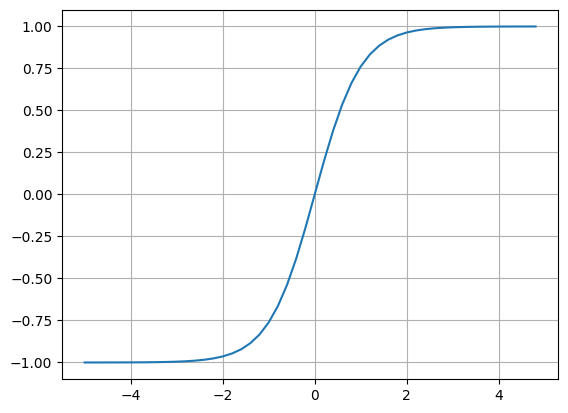

In [12]:
plt.plot(np.arange(-5, 5,.2),np.tanh(np.arange(-5, 5, .2))); plt.grid();

In [13]:
x1, x2 = Value(2., label='x1'), Value(0.0, label='x2')
w1, w2 = Value(-3., label='w1'), Value(1., label='w2')
b = Value(6.88137, label='b')

x1w1, x2w2 = x1 * w1, x2 * w2
x1w1.label = 'x1w1'; x2w2.label = 'x2w2'
x1w1Xx2w2 = x1w1 + x2w2 ; x1w1Xx2w2.label = 'x1w1x2w2'
n = x1w1Xx2w2 + b; n.label= 'n'
e= (2*n).exp(); e.label = 'e'
o = (e-1) / (e+1); o.label = 'o'
# f'(tanh) = 1 - tanh**2

In [14]:
# in order to automatically call backward we need to be at the output
# for that all nodes need to be in topological order
# https://en.wikipedia.org/wiki/Topological_sorting

In [15]:
o.backward()

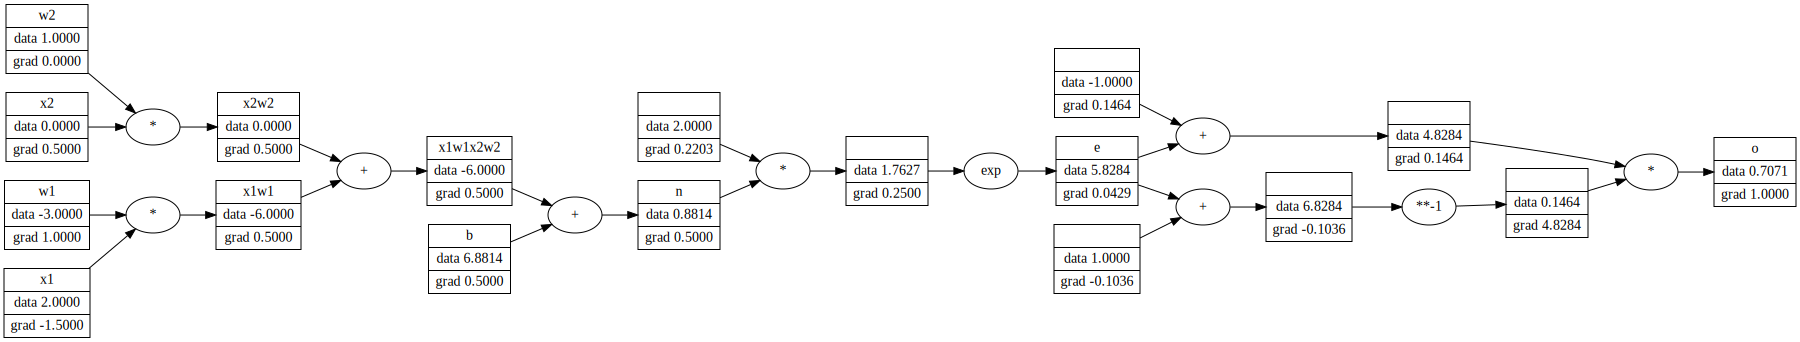

In [16]:
draw_dot(o)

# class for a neural network


In [17]:
class Neuron:
    """
    implements a neuron
    """
    def __init__(self,num_inputs):
        self.weight = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
        self.bias = Value(random.uniform(-1, 1))
    
    def __call__(self, inp):
        # w . x +b       call variable(inp) -> output
        activation = sum((wi*xi for wi,xi in zip(self.weight, inp)), self.bias)  # sum(generator, start)
        output = activation.tanh()
        return output
    
    def paramerters(self):
        """
        returns parameters of neuron
        """
        return self.weight + [self.bias]
    
    
class Layer:
    """
    single layer of neuron
    """
    def __init__(self, num_inputs, num_outputs):
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]
    
    def __call__(self, inp):
        outputs = [n(inp) for n in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

    def paramerters(self):
        """
        returns parameters of layer
        """
        params = []
        for neuron in self.neurons:
            params.extend(neuron.paramerters())
        return params
            
class MLP:
    """
    a multi layer perceptron
    """
    def __init__(self, num_inputs, num_outputs: list):
        sz = [num_inputs] + num_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_outputs))]
        
    def __call__(self, inp):
        for layer in self.layers:
            inp = layer(inp)
        return inp

    def paramerters(self):
        """
        returns parameters of neural network
        """
        return [p for layer in self.layers for p in layer.paramerters()]   # list comprehention same as layer.parameters()

In [18]:
x = [2., 3.,1.]  # 3 input neurons

n = MLP(3, [4, 4, 1]) # 3 Layers of 4, 4 and 1 output neuron

n(x),n.paramerters(),len(n.paramerters())  # activation of output

(Value(data=-0.20944567959964053),
 [Value(data=-0.01774144437448455),
  Value(data=-0.34103196535629254),
  Value(data=-0.012451970220099362),
  Value(data=0.7476977995186582),
  Value(data=-0.6587136401590004),
  Value(data=0.6899405187850318),
  Value(data=0.474612294097863),
  Value(data=0.9482167611335435),
  Value(data=0.1849075574435517),
  Value(data=0.04322034685867293),
  Value(data=-0.11765427128726258),
  Value(data=-0.431165469806464),
  Value(data=-0.24055589530994137),
  Value(data=-0.6338044188333907),
  Value(data=-0.4004177908938109),
  Value(data=-0.988569628748579),
  Value(data=0.9286317294248114),
  Value(data=-0.007237325749323231),
  Value(data=0.35899603572823335),
  Value(data=0.08641875149581546),
  Value(data=0.6091151693262833),
  Value(data=-0.717700583832628),
  Value(data=0.4807178272540118),
  Value(data=0.10949948491742179),
  Value(data=0.8365606872664351),
  Value(data=-0.7261367543480943),
  Value(data=0.5086212328816626),
  Value(data=0.54376540278

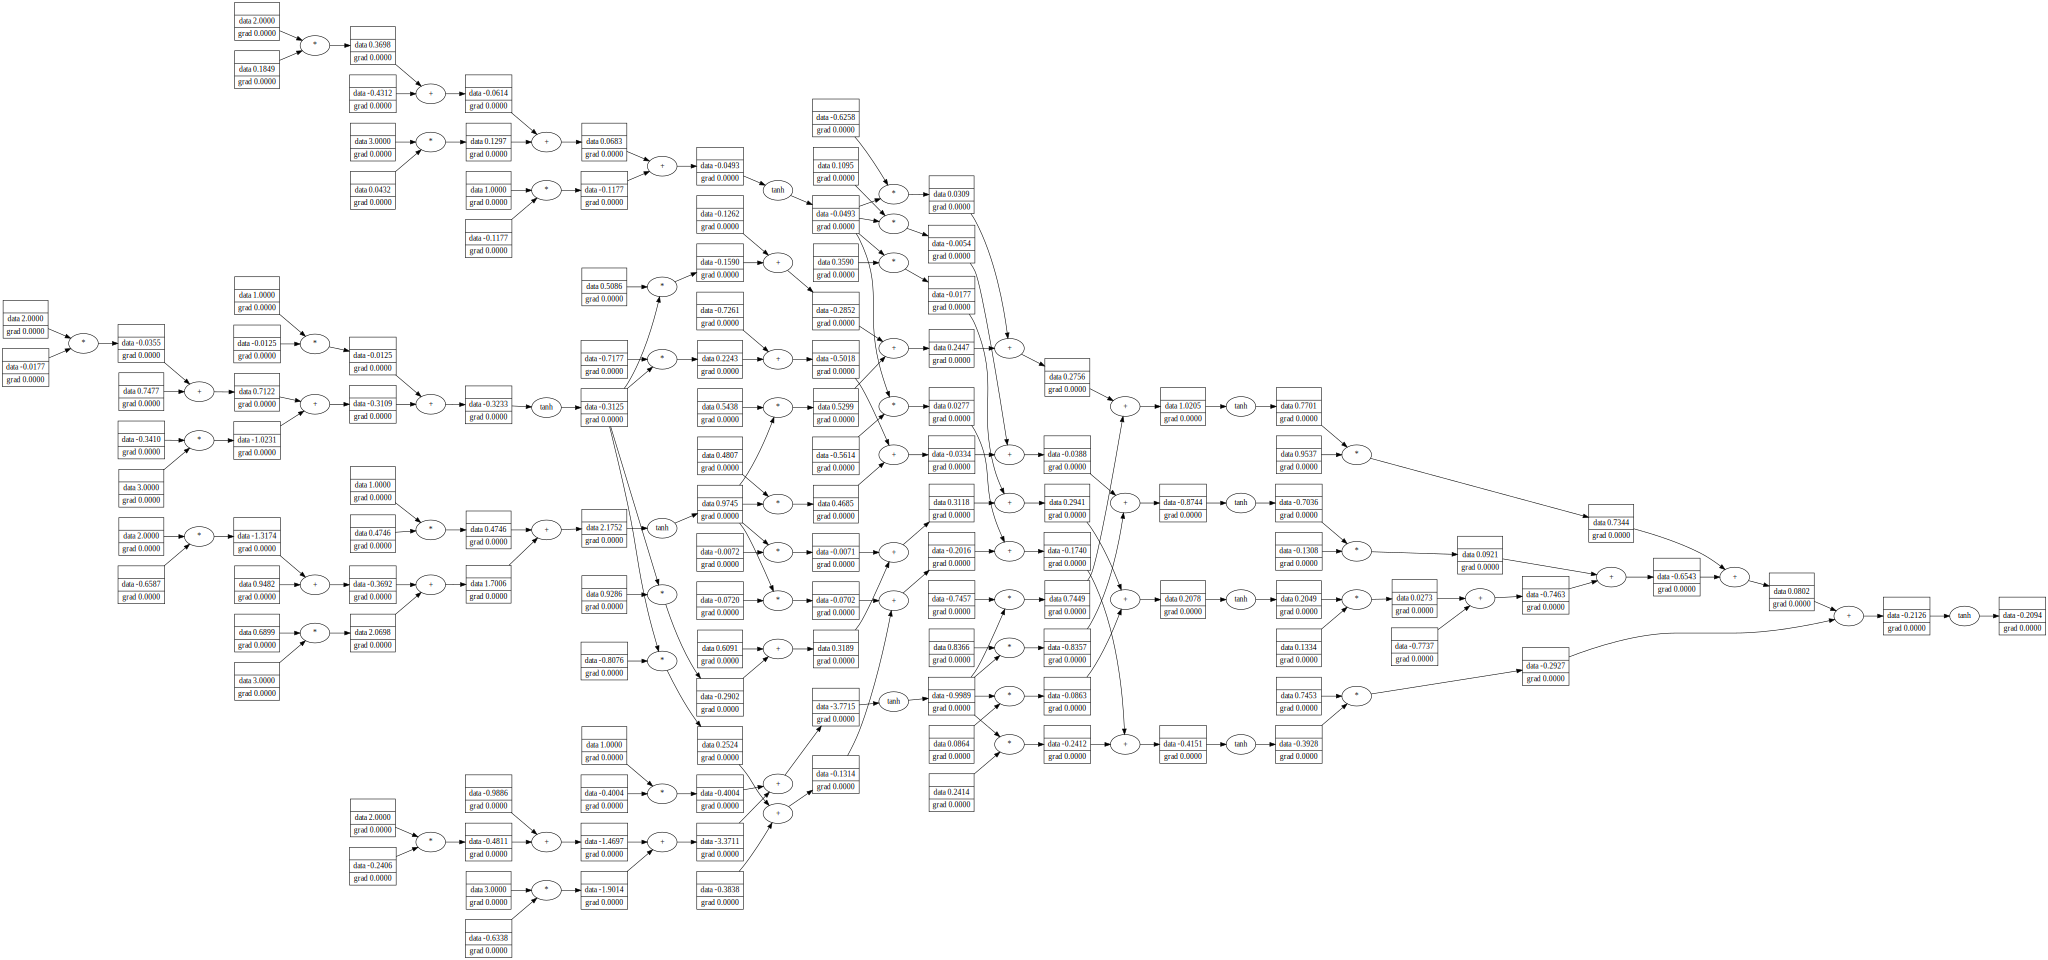

In [19]:
draw_dot(n(x))

In [20]:
xs = [[2.,3.,-1.],
      [3.,-1.,.5],
      [.5,1.,1.],
      [1.,1.,-1.]]
ys = [1., -1. ,-1. ,1] # desired output
ypreds = [n(i) for i in xs]
ypreds

[Value(data=-0.3574496275580026),
 Value(data=-0.6526424705715584),
 Value(data=-0.1825978849140159),
 Value(data=-0.336791089335388)]

In [21]:
loss = sum([(out - ygt)**2 for ygt, out in zip(ys,ypreds)])
loss

Value(data=4.4184833788815245)

 # Gradient Descent

In [22]:
ypreds = [n(i) for i in xs]

In [23]:
loss.backward()

In [24]:
ypreds

[Value(data=-0.3574496275580026),
 Value(data=-0.6526424705715584),
 Value(data=-0.1825978849140159),
 Value(data=-0.336791089335388)]

In [25]:
n.layers[0].neurons[0].weight[0].grad,n.layers[0].neurons[0].weight[0].data  # becomes more sensitive as descending

(0.16463778864072884, -0.01774144437448455)

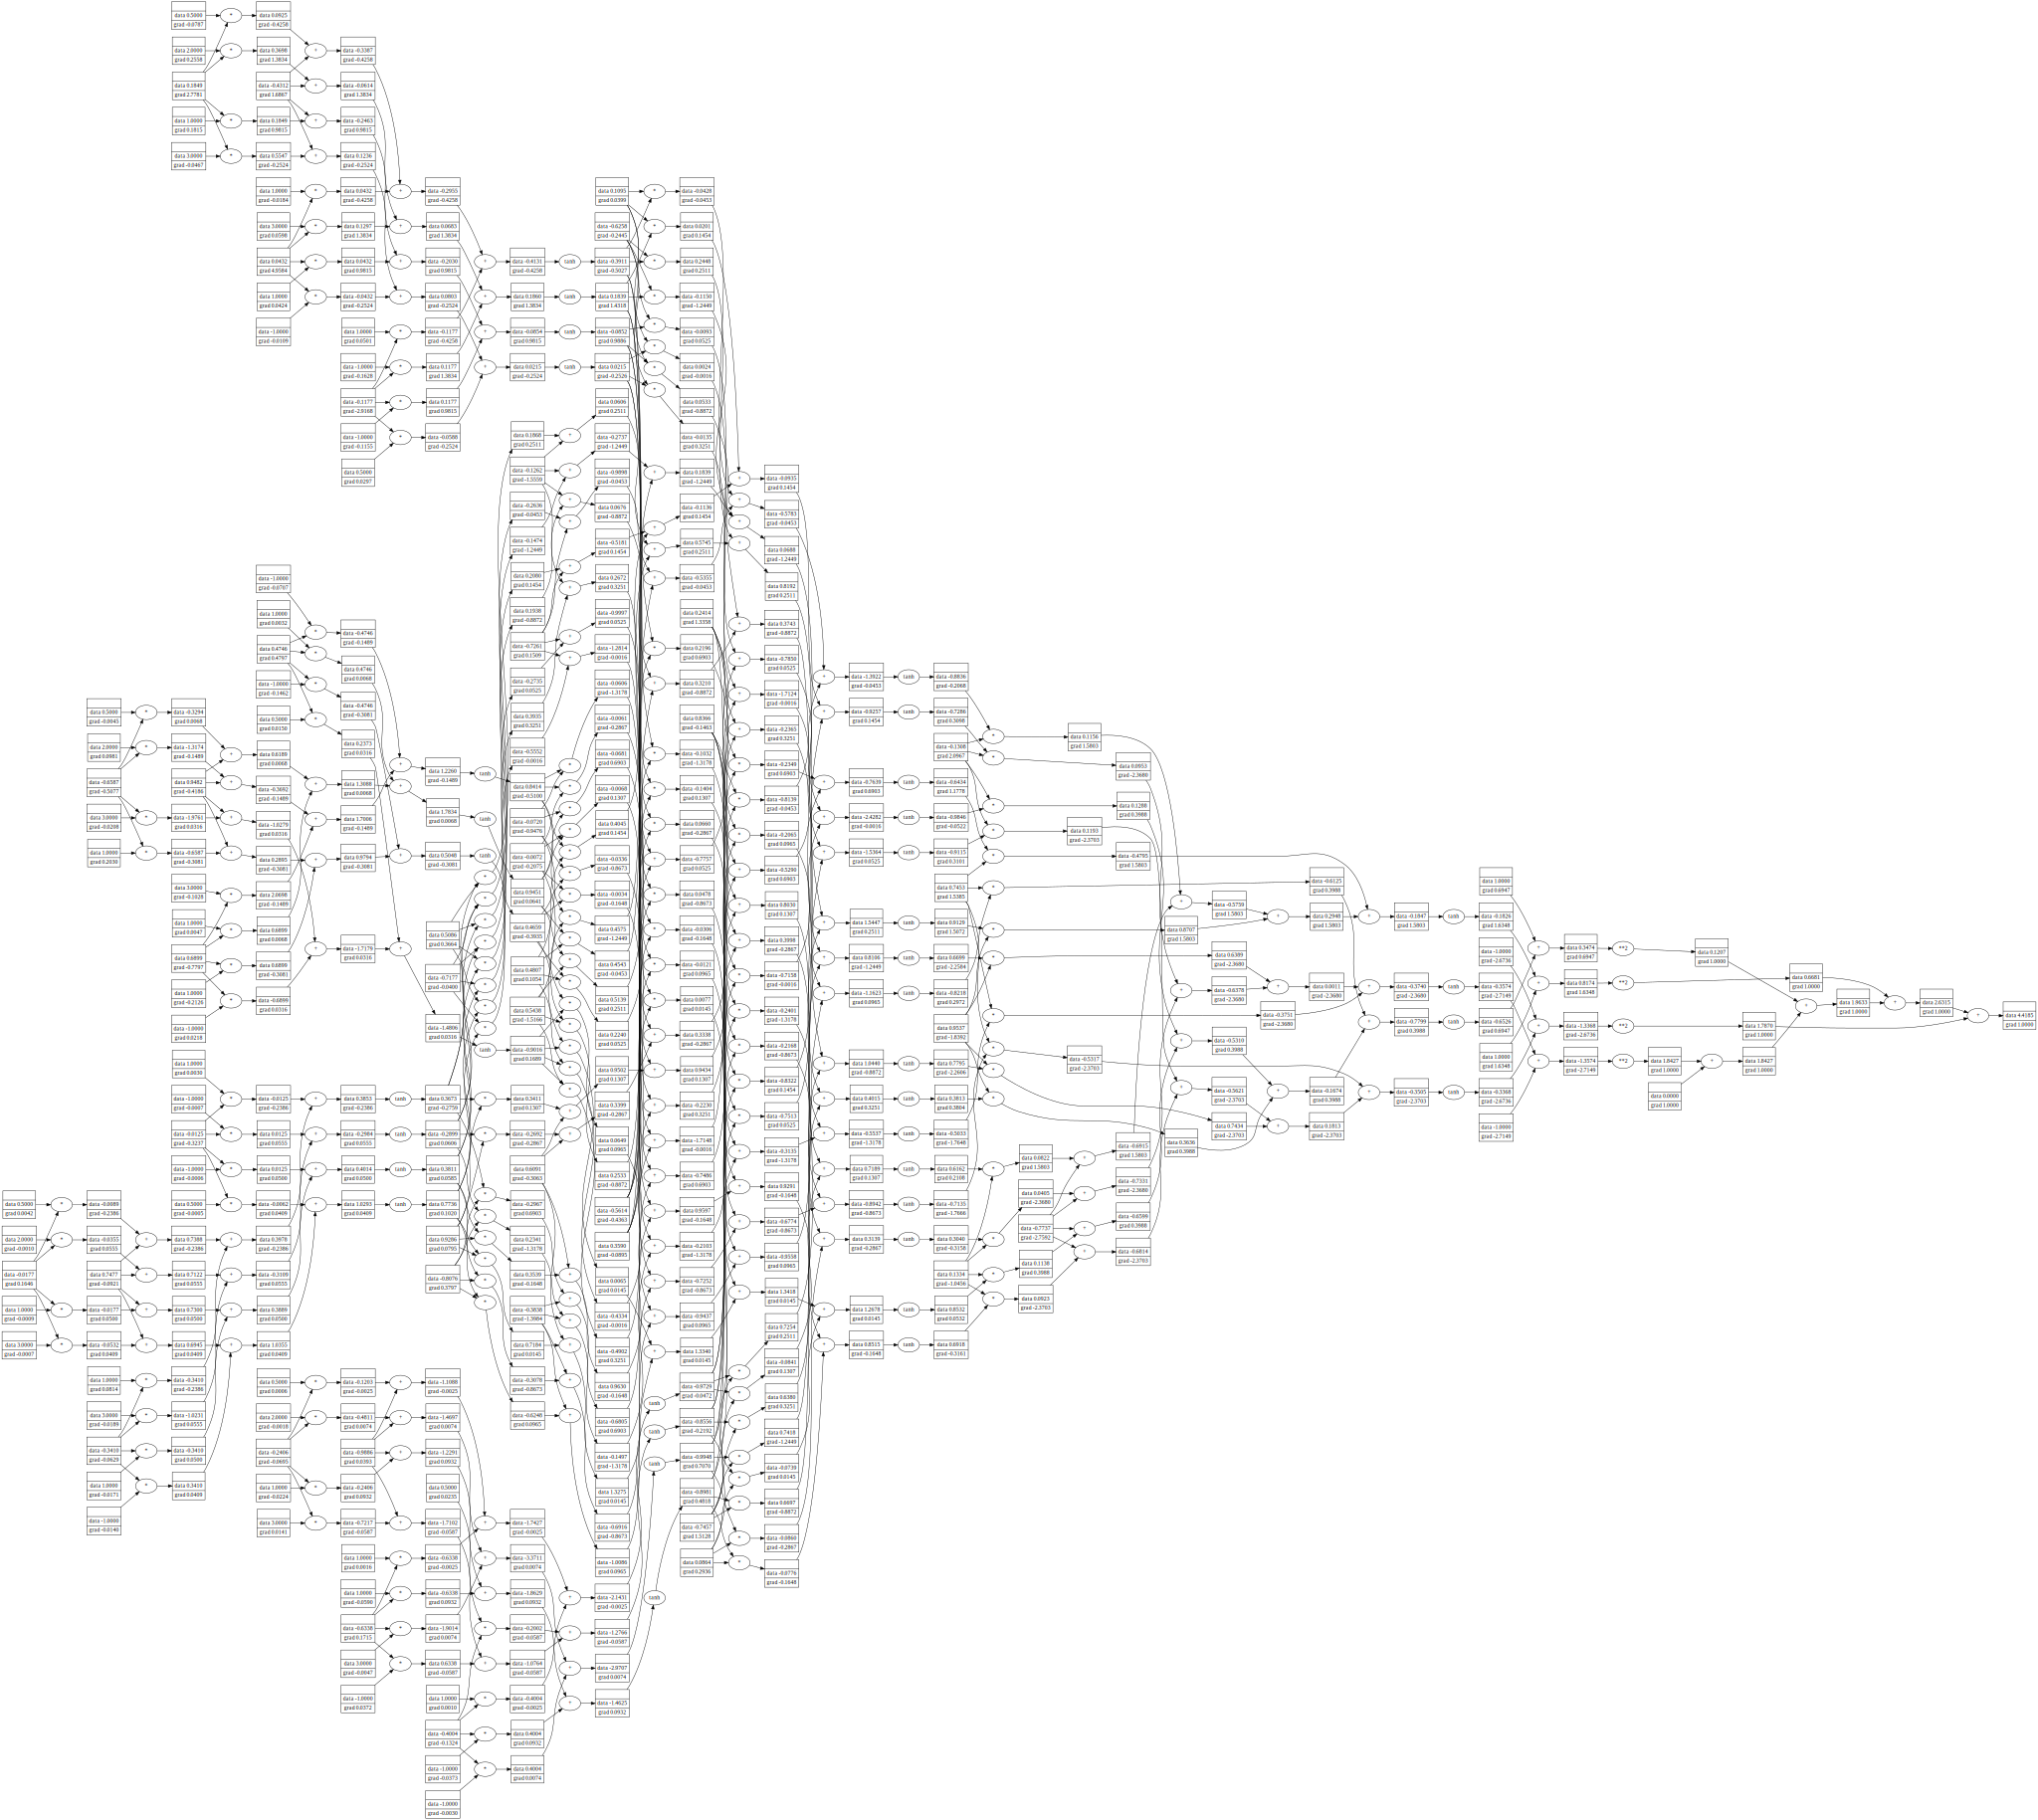

In [26]:
draw_dot(loss)

In [27]:
net = MLP(3, [4, 4, 1])


x_s = [[2.,3.,-1.],
      [3.,-1.,.5],
      [.5,1.,1.],
      [1.,1.,-1.]]
y_s = [1., -1. ,-1. ,1]

for k in range(70):
    yp = [net(i) for i in x_s]
    l = sum([(out - ygt)**2 for ygt, out in zip(y_s,yp)])

    for p in net.paramerters():
        p.grad = 0.   #  ensure p.grad is 0 after every iteration so, they don't add up   from  self.grad '+=' out.data * out.grad
        
    l.backward()

    for p in net.paramerters():
        p.data += -.05 * p.grad
    print(k, l.data)
    

0 1.0820668706665884
1 0.6466539985727132
2 0.3917159354866843
3 0.2587438839875421
4 0.1862533230775734
5 0.1427508080861778
6 0.11443213870566186
7 0.09480703962659878
8 0.08053223883923222
9 0.06974743391587537
10 0.061348470443388425
11 0.05464410899167797
12 0.049182041777952254
13 0.04465513449851495
14 0.04084818533001747
15 0.0376063049042922
16 0.034815396897404156
17 0.03238969721251226
18 0.03026358226420367
19 0.028386042683827946
20 0.026716868680328423
21 0.025223962462025087
22 0.023881409621752885
23 0.02266807203342027
24 0.02156654570376384
25 0.020562378295078693
26 0.019643474226988054
27 0.018799637172762833
28 0.01802221448337018
29 0.017303818122236227
30 0.016638103659944947
31 0.016019593774430796
32 0.0154435361883348
33 0.01490578848717566
34 0.014402724092384276
35 0.01393115501100569
36 0.013488267986003201
37 0.01307157142311273
38 0.012678851039412216
39 0.012308132613140052
40 0.01195765054831837
41 0.01162582122646529
42 0.011311220319464053
43 0.011012

In [28]:
yp

[Value(data=0.9668717216895738),
 Value(data=-0.9890391239109568),
 Value(data=-0.9455816513536494),
 Value(data=0.9521403666536553)]

In [29]:
net.paramerters()

[Value(data=0.8861702102528066),
 Value(data=0.12761126755276753),
 Value(data=0.4682419020204812),
 Value(data=0.44378491826587935),
 Value(data=0.5308749024716582),
 Value(data=-0.03212076840636478),
 Value(data=0.11970934801463662),
 Value(data=0.6950639255811735),
 Value(data=0.45874592134409686),
 Value(data=-0.5505059578745317),
 Value(data=1.1003841068850826),
 Value(data=-0.09869936842298403),
 Value(data=-0.236052152056569),
 Value(data=0.686154026088286),
 Value(data=-0.6633510121789875),
 Value(data=-0.0190526487162436),
 Value(data=-0.13079893573062285),
 Value(data=0.9003674513786787),
 Value(data=0.3528777897154496),
 Value(data=-0.7713509310038364),
 Value(data=-0.014942632659093933),
 Value(data=0.7709674155963109),
 Value(data=0.1237089629413575),
 Value(data=0.7933355117666309),
 Value(data=-0.2314621381416892),
 Value(data=-0.701409168905765),
 Value(data=-0.25182478393460156),
 Value(data=0.15730236886361212),
 Value(data=0.38838535163363525),
 Value(data=-0.9001254